In [1]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob
import matplotlib.pyplot as plt

import torch
CLOUD = not torch.cuda.is_available()

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']

In [2]:
# BitsAllocated - remove only one value
# HighBit - remove, same as BitsStored
# BitsStored and PixelRepresentation, - switch to 3 booleans. And WindowCenter_1_NAN + RescaleIntercept = 7 OHE
# ImageOrientationPatient_0, mostly 1, 157 zeros, rest > 0.8. Do it 1 or not 
# ImageOrientationPatient_1 zero or not
# ImageOrientationPatient_2 zero or not
# ImageOrientationPatient_3 zero or not
# ImageOrientationPatient_4 one or not, clip 0.85 to 1, between(0.927184,0.927185), push two special grps to 0.7
# ImageOrientationPatient_5 zero or not, between(-0.374608,-0.374607), two groups to 0.5
# ImagePositionPatient_0 clip -200;-50, -125 category, between(-126.437379,-126.437377)+between(-126.408876,-126.408874)
# groups to -250
# ImagePositionPatient_1 clip -200 to 100, bool for more than -75
# ((train_md.ImagePositionPatient_2 % 0.5) == 0) clip -500,1500
# PixelSpacing_1 between(0.488281,0.488282), clip 0.3;0.7, between(0.494750,0.494864)+between(0.494750,0.494864)
# PixelSpacing_0 duplicate, drop
# WindowCenter_0 group all with less than 1000 app, embedding for 7 groups
# WindowCenter_1 all <1000 cat, NaN cat, and 3 more, - into emb of 5
# pos_inc clip 0,7. 0 and 5 into cats and val -1. 
# pos_inc from other side
# pos_inc [2.0,3.5,4.5] embedding 4 cat
# (((train_md.pos_inc+0.0000001) % 1) < 0.00001).value_counts()
# (((train_md.pos_inc+0.0000001) % 0.001) < 0.00001).value_counts()
# pos_min, pos_max clip -500;500
# pos_size leave as it is, add 10 embedding for the most common
# add pos_idx from tail
# pos_range clip 100,250
# (((train_md.pos_range + 1e-6) % 1) < 1e-3).value_counts()
# pos_zeros all <1000 into one and 4 cat embedding
# pos_inc_rng clip 1,3

# Utility

In [3]:
def myLabelEncoder(data, col, vals, remaining_cat = True):
    name = col+'_le'
    enc_df = pd.DataFrame(np.arange(len(vals)), index=vals, columns = [name])
    data = data.join(enc_df, on=col)

    if remaining_cat:
        data[name] = data[name].fillna(len(vals))
    else:
        assert data[name].isnull().sum() == 0
    
    data[name] = data[name].astype(int).astype('category')
    assert len(data[name].unique()) == (len(vals) + remaining_cat)
    
    return data

In [4]:
def myRoundEncoder(data, col, rounding, postfix):
    name = col+postfix
    data[name] = (((data[col]+0.0000001) % rounding) < 0.00001)
    data[name] = data[name].astype(bool)
    return data

# Prepare metadata

In [46]:
cols_info = ['PatientID','SOPInstanceUID','SeriesInstanceUID','StudyInstanceUID']
cols_redundant = ['BitsAllocated','HighBit','WindowCenter_1_NAN','ImageOrientationPatient_0','ImageOrientationPatient_1',
                  'ImageOrientationPatient_2','ImageOrientationPatient_3','PixelSpacing_0','Modality',
                  'PhotometricInterpretation','SamplesPerPixel','StudyID',
                  'ImageOrientationPatient_5_enc_1', # same as ImageOrientationPatient_4_enc_1
                  'PixelSpacing_1_enc_1', # same as ImagePositionPatient_0_enc_1
                 ]
cols_consumed = ['BitsStored','PixelRepresentation','RescaleIntercept','ImageOrientationPatient',
                 'ImageOrientationPatient_4','ImageOrientationPatient_5','ImagePositionPatient',
                 'ImagePositionPatient_0','ImagePositionPatient_1','ImagePositionPatient_2','PixelSpacing',
                 'RescaleSlope','WindowCenter','PixelSpacing_1','WindowCenter_0','WindowCenter_1',
                 'WindowWidth','WindowWidth_0','WindowWidth_1']
cols_float = ['ImageOrientationPatient_4_f','ImageOrientationPatient_5_f','ImagePositionPatient_0_f',
              'ImagePositionPatient_1_f','ImagePositionPatient_2_f','PixelSpacing_1_f',
              'pos_max','pos_min','pos_size','pos_idx1','pos_idx2','pos_inc1','pos_inc2',
              'pos_range','pos_rel','pos_zeros','pos_inc_rng']
cols_bool = ['ImageOrientationPatient_4_enc_0','ImageOrientationPatient_4_enc_1',
             'ImageOrientationPatient_5_enc_0',
             'ImagePositionPatient_0_enc_0','ImagePositionPatient_0_enc_1',
             'ImagePositionPatient_0_f_r1','ImagePositionPatient_0_f_r05','ImagePositionPatient_1_enc_0',
             'ImagePositionPatient_2_f_r05','PixelSpacing_1_enc_0',
             'pos_inc1_r1','pos_inc1_r0001','pos_inc1_enc_0','pos_inc2_enc_0','pos_inc1_enc_1','pos_inc2_enc_1']
cols_le = ['WindowCenter_1_le','BitType_le','WindowCenter_0_le','pos_inc1_grp_le','pos_inc2_grp_le','pos_size_le',
           'pos_zeros_le','WindowWidth_0_le','WindowWidth_1_le']

cols_all = cols_redundant + cols_float + cols_bool + cols_le + cols_consumed + cols_info

In [47]:
pickle.dump((cols_le,cols_float,cols_bool), open(PATH_WORK/'covs','wb'))

In [7]:
train_csv = pd.read_csv(PATH/'stage_1_train.csv')

train_csv = train_csv.loc[~train_csv.ID.duplicated()].sort_values('ID').reset_index(drop=True)
all_sop_ids = train_csv.ID.str.split('_').apply(lambda x: x[0]+'_'+x[1]).unique()
train_df = pd.DataFrame(train_csv.Label.values.reshape((-1,6)), columns = all_ich)
train_df['sop_id'] = all_sop_ids

train_df.to_csv(PATH_WORK/'train_df.csv', index=False)

In [8]:
train_md = pd.read_csv(PATH/'train_metadata.csv')
test_md = pd.read_csv(PATH/'test_metadata.csv')
test_md = test_md.sort_values('SOPInstanceUID')
data_md = pd.concat([train_md, test_md], axis=0, sort=False).reset_index(drop=True)

In [9]:
del data_md['Unnamed: 0']

In [10]:
for i in range(6):
    data_md['ImageOrientationPatient_{}'.format(i)] \
        = data_md['ImageOrientationPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(3):
    data_md['ImagePositionPatient_{}'.format(i)] \
        = data_md['ImagePositionPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(2):
    data_md['PixelSpacing_{}'.format(i)] \
        = data_md['PixelSpacing'].str.split('\'').apply(lambda x: x[1+2*i])

data_md['WindowCenter_0'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[1]) if len(x) > 1 else float(x[0]))

data_md['WindowCenter_1'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[3]) if len(x) > 1 else np.nan)

data_md['WindowCenter_1_NAN'] = data_md.WindowCenter_1.isnull()

In [11]:
data_md['WindowWidth_0'] \
    = data_md['WindowWidth'].str.split('\'').apply(lambda x: float(x[1]) if len(x) > 1 else float(x[0]))

data_md['WindowWidth_1'] \
    = data_md['WindowWidth'].str.split('\'').apply(lambda x: float(x[3]) if len(x) > 1 else np.nan)

data_md = myLabelEncoder(data_md, 'WindowWidth_0', [80.0,150.0,100.0,135.0,120.0])

data_md = myLabelEncoder(data_md, 'WindowWidth_1', [80.0,np.nan])

In [12]:
data_md['ImagePositionPatient_2'] = data_md['ImagePositionPatient_2'].astype(float)
data_md = data_md.sort_values(['SeriesInstanceUID','ImagePositionPatient_2']).reset_index(drop=True)

In [13]:
data_md = myLabelEncoder(data_md, 'WindowCenter_1', [36.0,40.0,47.0,np.nan])

In [14]:
data_md['BitType'] = data_md.BitsStored.astype(str) + data_md.PixelRepresentation.astype(str) \
    + data_md.RescaleIntercept.astype(str)

data_md = myLabelEncoder(data_md, 'BitType', ['161-1024.0','120-1024.0','1210.0','1610.0'])

del data_md['BitType']

In [15]:
data_md['ImageOrientationPatient_4_f'] = data_md.ImageOrientationPatient_4.astype(float)

data_md['ImageOrientationPatient_4_enc_0'] = (data_md.ImageOrientationPatient_4_f == 1)
data_md['ImageOrientationPatient_4_enc_1'] = data_md.ImageOrientationPatient_4_f.between(0.927184,0.927185)

data_md['ImageOrientationPatient_4_f'] = np.clip(data_md['ImageOrientationPatient_4_f'].values,0.85,1)

data_md.loc[data_md.ImageOrientationPatient_4_enc_0 | data_md.ImageOrientationPatient_4_enc_1, \
            'ImageOrientationPatient_4_f'] = 0.7

In [16]:
data_md['ImageOrientationPatient_5_f'] = data_md.ImageOrientationPatient_5.astype(float)

data_md['ImageOrientationPatient_5_enc_0'] = (data_md.ImageOrientationPatient_5_f == 0)
data_md['ImageOrientationPatient_5_enc_1'] = data_md.ImageOrientationPatient_5_f.between(-0.374608,-0.374607)

data_md.loc[data_md.ImageOrientationPatient_5_enc_0 | data_md.ImageOrientationPatient_5_enc_1, \
            'ImageOrientationPatient_5_f'] = -0.6

data_md['ImageOrientationPatient_5_f'] = np.clip(data_md['ImageOrientationPatient_5_f'].values,-0.7,0)

In [17]:
data_md['ImagePositionPatient_0_f'] = data_md.ImagePositionPatient_0.astype(float)

data_md['ImagePositionPatient_0_enc_0'] = (data_md.ImagePositionPatient_0_f == -125)
data_md['ImagePositionPatient_0_enc_1'] = (data_md.ImagePositionPatient_0_f.between(-126.437379,-126.437377) |
                                           data_md.ImagePositionPatient_0_f.between(-126.408876,-126.408874))

data_md['ImagePositionPatient_0_f'] = np.clip(data_md['ImagePositionPatient_0_f'].values,-175,-50)

data_md.loc[data_md.ImagePositionPatient_0_enc_0 | data_md.ImagePositionPatient_0_enc_1, \
            'ImagePositionPatient_0_f'] = -200

In [18]:
data_md = myRoundEncoder(data_md, 'ImagePositionPatient_0_f', 1, '_r1')
data_md = myRoundEncoder(data_md, 'ImagePositionPatient_0_f', 0.5, '_r05')

In [19]:
data_md['ImagePositionPatient_1_f'] = data_md.ImagePositionPatient_1.astype(float)
data_md['ImagePositionPatient_1_f'] = np.clip(data_md['ImagePositionPatient_1_f'].values,-200,100)
data_md['ImagePositionPatient_1_enc_0'] = (data_md['ImagePositionPatient_1_f'] > -75)

In [20]:
data_md['ImagePositionPatient_2_f'] = data_md.ImagePositionPatient_2.astype(float)
data_md = myRoundEncoder(data_md, 'ImagePositionPatient_2_f', 0.5, '_r05')

In [21]:
data_md['PixelSpacing_1_f'] = data_md.PixelSpacing_1.astype(float)

data_md['PixelSpacing_1_enc_0'] = (data_md.PixelSpacing_1_f.between(0.488281,0.488282))
data_md['PixelSpacing_1_enc_1'] = (data_md.PixelSpacing_1_f.between(0.494750,0.494864))

data_md['PixelSpacing_1_f'] = np.clip(data_md['PixelSpacing_1_f'].values,0.3,0.7)

data_md.loc[data_md.PixelSpacing_1_enc_0 | data_md.PixelSpacing_1_enc_1, 'PixelSpacing_1_f'] = 0.2

In [22]:
data_md = myLabelEncoder(data_md, 'WindowCenter_0', [30.0,36.0,40.0,35.0,47.0,50.0])

In [23]:
data_md['pos_max'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: max(x))
data_md['pos_min'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: min(x))
data_md['pos_size'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: len(x))

In [24]:
data_md['pos_idx1'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.arange(len(x)))

In [25]:
data_md['pos_idx2'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.arange(len(x))[::-1])

In [26]:
data_md['pos_inc1'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.concatenate([[0],np.diff(x.values)]))
data_md['pos_inc2'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.concatenate([np.diff(x.values),[0]]))

In [27]:
data_md['pos_inc1_grp'] = pd.cut(data_md.pos_inc1, [-1,2.0,3.5,4.5,1000], labels=np.arange(4))
data_md = myLabelEncoder(data_md, 'pos_inc1_grp', [0,1,2,3], remaining_cat=False)

del data_md['pos_inc1_grp']

data_md['pos_inc2_grp'] = pd.cut(data_md.pos_inc2, [-1,2.0,3.5,4.5,1000], labels=np.arange(4))
data_md = myLabelEncoder(data_md, 'pos_inc2_grp', [0,1,2,3], remaining_cat=False)

del data_md['pos_inc2_grp']

In [28]:
data_md = myRoundEncoder(data_md, 'pos_inc1', 1, '_r1')
data_md = myRoundEncoder(data_md, 'pos_inc1', 0.001, '_r0001')

In [29]:
data_md['pos_inc1_enc_0'] = (data_md.pos_inc1 == 0)
data_md['pos_inc2_enc_0'] = (data_md.pos_inc2 == 0)
data_md['pos_inc1_enc_1'] = (data_md.pos_inc1 == 5)
data_md['pos_inc2_enc_1'] = (data_md.pos_inc2 == 5)

data_md['pos_inc1'] = np.clip(data_md['pos_inc1'].values,0,7)
data_md['pos_inc2'] = np.clip(data_md['pos_inc2'].values,0,7)

data_md.loc[data_md.pos_inc1_enc_0 | data_md.pos_inc1_enc_1, 'pos_inc1'] = -1
data_md.loc[data_md.pos_inc2_enc_0 | data_md.pos_inc2_enc_1, 'pos_inc2'] = -1

In [30]:
data_md = myLabelEncoder(data_md, 'pos_size', [32,40,36,28,34,30,35,33,38,44])

In [31]:
data_md['pos_range'] = (data_md['pos_max'] - data_md['pos_min'])
data_md['pos_rel'] = ((data_md['ImagePositionPatient_2'] - data_md['pos_min'])/data_md['pos_range'])\
    .where(data_md['pos_range'] > 0, 0.5)

data_md['pos_zeros'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: (np.diff(x.values) <= 0.001).sum())

data_md['pos_inc_rng'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.diff(x.values)[np.diff(x.values) > 0.1].max() /
                                                      np.diff(x.values)[np.diff(x.values) > 0.1].min())

data_md['pos_inc_rng'] = np.clip(data_md['pos_inc_rng'],0,3)

In [32]:
data_md['pos_min'] = np.clip(data_md['pos_min'].values,-500,500)
data_md['pos_max'] = np.clip(data_md['pos_max'].values,-500,500)

In [33]:
data_md['pos_range'] = np.clip(data_md['pos_range'].values,100,250)

data_md = myLabelEncoder(data_md, 'pos_zeros', [0,4,8])

In [34]:
assert len([col for col in cols_all if col not in data_md.columns]) == 0
assert len([col for col in data_md.columns if col not in (cols_all + all_ich)]) == 0

In [35]:
data_md = data_md.join(train_df.set_index('sop_id'), on = 'SOPInstanceUID')

In [36]:
assert data_md['any'].isnull().sum() == 78545
assert (~data_md['any'].isnull()).sum() == 674258

In [37]:
for col in (cols_float + cols_bool):
    data_md[col] = data_md[col].astype(float)

#for col in cols_cat:
#    data_md[col] = pd.factorize(data_md[col])[0]
#    data_md[col] = data_md[col].astype('category')

In [60]:
data_md['ImageOrientationPatient_4_f'] = 2*(data_md['ImageOrientationPatient_4_f'] - 0.8)/0.3
data_md['ImageOrientationPatient_5_f'] = 2*(data_md['ImageOrientationPatient_5_f'] + 0.5)/0.6
data_md['ImagePositionPatient_0_f'] =    2*(data_md['ImagePositionPatient_0_f'] + 173)/150
data_md['ImagePositionPatient_1_f'] =    2*(data_md['ImagePositionPatient_1_f'] + 65)/300
data_md['ImagePositionPatient_2_f'] =    2*(data_md['ImagePositionPatient_2_f'] - 167)/2792
data_md['PixelSpacing_1_f'] =            2*(data_md['PixelSpacing_1_f'] - 0.26)/0.5
data_md['pos_max'] =                     2*(data_md['pos_max'])/1000
data_md['pos_min'] =                     2*(data_md['pos_min'])/1000
data_md['pos_size'] =                    2*(data_md['pos_size'] - 35)/40
data_md['pos_idx1'] =                    2*(data_md['pos_idx1'] - 17)/59
data_md['pos_idx2'] =                    2*(data_md['pos_idx2'] - 17)/59
data_md['pos_inc1'] =                    2*(data_md['pos_inc1'] - 2)/8
data_md['pos_inc2'] =                    2*(data_md['pos_inc2'] - 2)/8
data_md['pos_range'] =                   2*(data_md['pos_range'] - 165)/150
data_md['pos_rel'] =                     2*(data_md['pos_rel'] - 0.5)/1.0
data_md['pos_zeros'] =                   2*(data_md['pos_zeros'])/10
data_md['pos_inc_rng'] =                 2*(data_md['pos_inc_rng'] - 1.3)/2.0

In [38]:
data_md.to_csv(PATH_WORK/'data_md.csv', index=False)

In [59]:
data_md = pd.read_csv(PATH_WORK/'data_md.csv')

In [62]:
train_md = data_md.loc[~data_md['any'].isnull()].copy().reset_index(drop=True)
for col in all_ich:
    train_md[col] = train_md[col].astype(int)
train_md.to_csv(PATH_WORK/'train_md.csv', index=False)

test_md = data_md.loc[data_md['any'].isnull()].copy().reset_index(drop=True)
test_md.to_csv(PATH_WORK/'test_md.csv', index=False)

In [63]:
for col in cols_le:
    print(col, len(data_md[col].unique()))

WindowCenter_1_le 5
BitType_le 5
WindowCenter_0_le 7
pos_inc1_grp_le 4
pos_inc2_grp_le 4
pos_size_le 11
pos_zeros_le 4
WindowWidth_0_le 6
WindowWidth_1_le 3


In [104]:
cnts = data_md[['SeriesInstanceUID'] + cols_bool]\
    .groupby('SeriesInstanceUID').agg(lambda x: len(x.unique()))

In [98]:
cnts.sum()/cnts.shape[0]

WindowCenter_1_le    1.000000
BitType_le           1.000046
WindowCenter_0_le    1.001794
pos_inc1_grp_le      2.202033
pos_inc2_grp_le      2.202033
pos_size_le          1.000000
pos_zeros_le         1.000000
WindowWidth_0_le     1.023225
WindowWidth_1_le     1.000000
dtype: float64

In [100]:
cnts.sum()/cnts.shape[0]

ImageOrientationPatient_4_enc_0    1.000184
ImageOrientationPatient_4_enc_1    1.000184
ImageOrientationPatient_5_enc_0    1.000184
ImagePositionPatient_0_enc_0       1.000046
ImagePositionPatient_0_enc_1       1.000000
ImagePositionPatient_0_f_r1        1.000046
ImagePositionPatient_0_f_r05       1.000092
ImagePositionPatient_1_enc_0       1.000092
ImagePositionPatient_2_f_r05       1.025570
PixelSpacing_1_enc_0               1.000000
pos_inc1_r1                        1.671036
pos_inc1_r0001                     1.432763
pos_inc1_enc_0                     2.000000
pos_inc2_enc_0                     2.000000
pos_inc1_enc_1                     1.428532
pos_inc2_enc_1                     1.428532
dtype: float64

In [167]:
significant_cols = []

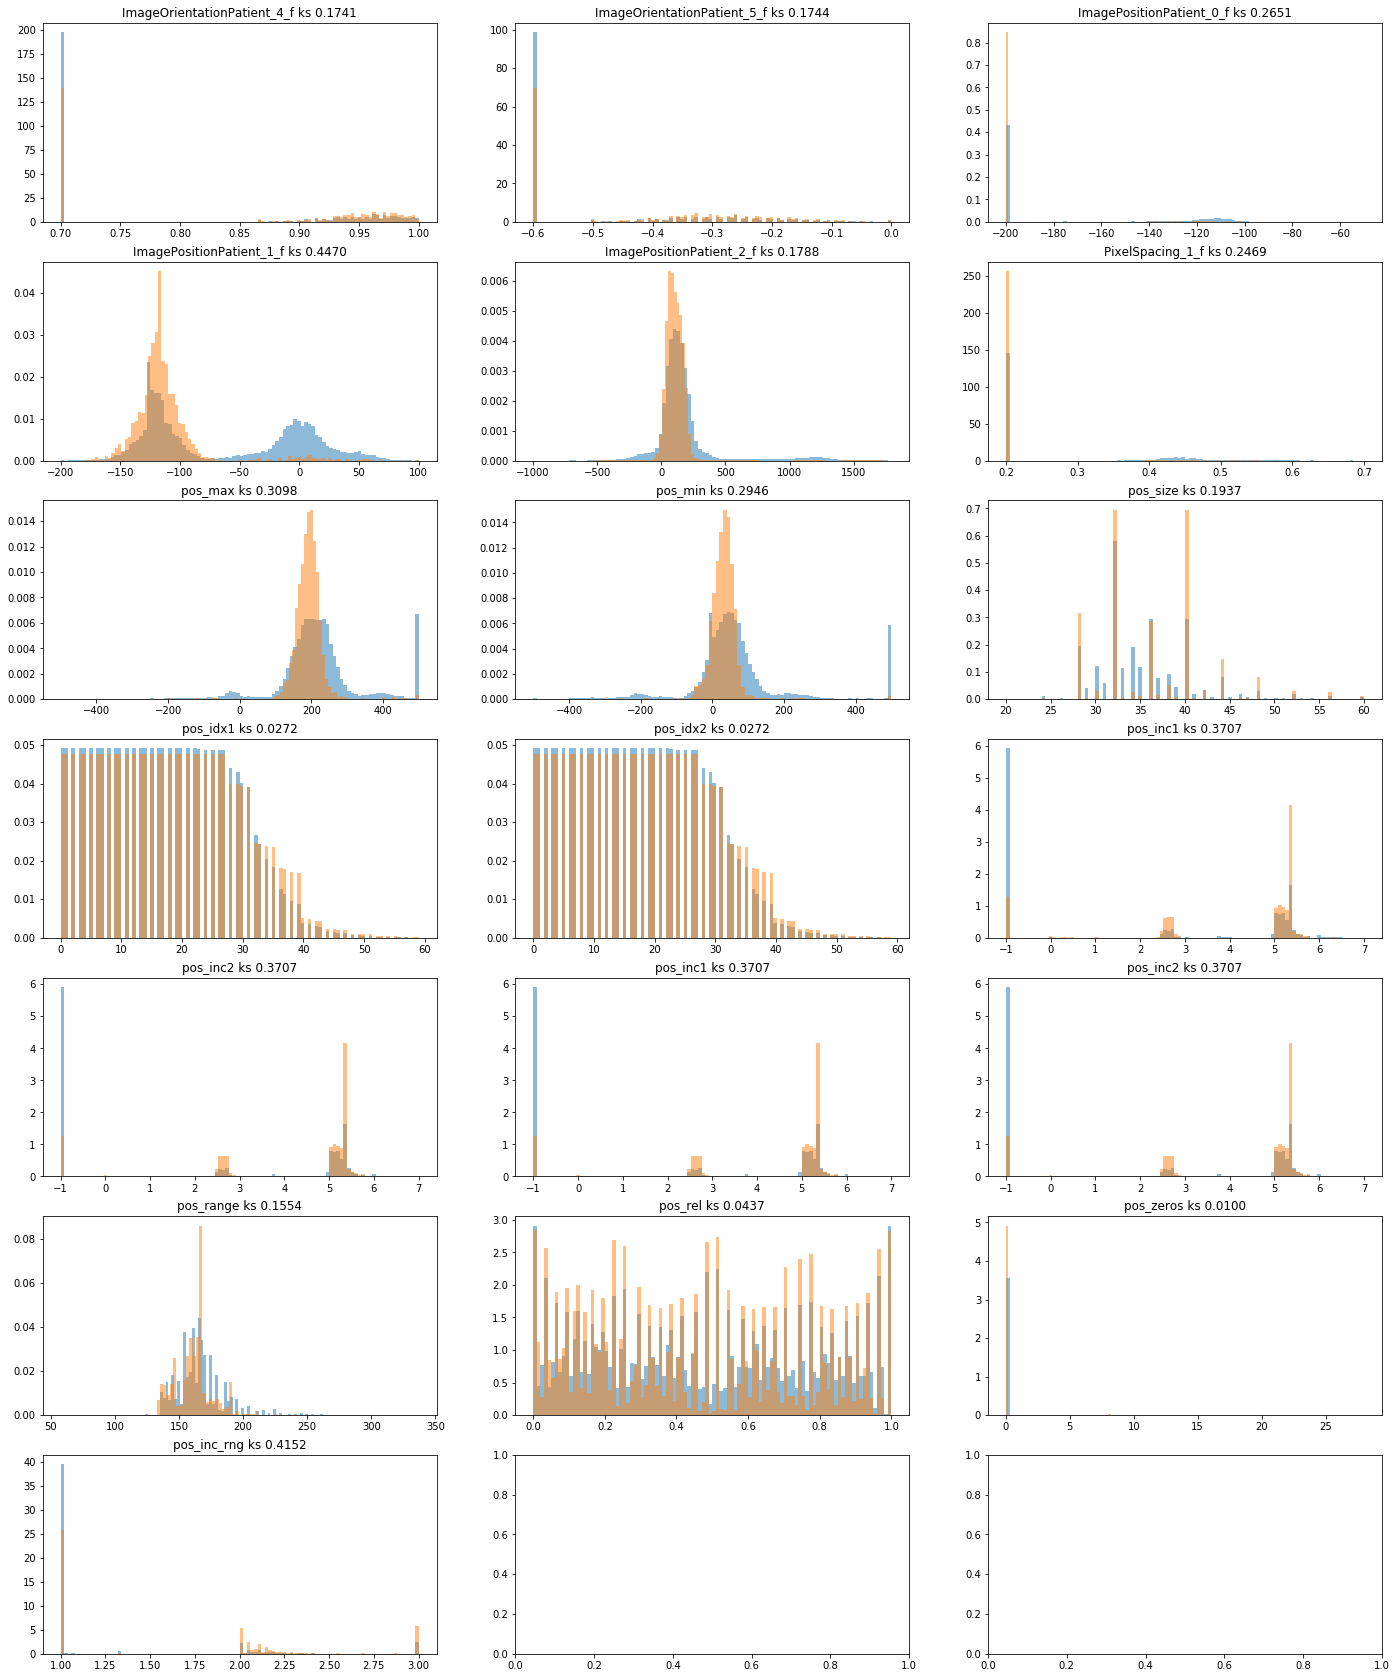

In [169]:
fig, axes = plt.subplots(7, 3, figsize=(24, 30))

for i, ax in enumerate(axes.flatten()):
    if i >= len(cols_float): continue
    col = cols_float[i]
    a = ax.hist(train_md[col], bins=100, density=True, alpha=0.5)
    a = ax.hist(test_md[col], bins=100, density=True, alpha=0.5)
    ks = ks_2samp(train_md[col].values, test_md[col].values)
    ax.set_title(col + (' IMPORTANT' if col in significant_cols else '') + ' ks {:.4f}'.format(ks.statistic))

In [79]:
for col in cols_le:
    print(pd.crosstab(data_md[col], data_md['any'].isnull()))

any                 False  True 
WindowCenter_1_le               
0                  248152   2157
1                   70894    985
2                   10377     34
3                  341679  75369
4                    3156      0
any          False  True 
BitType_le               
0           338728  75369
1           323551   3088
2             2252     60
3             2951      0
4             6776     28
any                 False  True 
WindowCenter_0_le               
0                  213405  69272
1                  248152   2157
2                  151196   2148
3                   43652   4934
4                   10343     34
5                    3957      0
6                    3553      0
any               False  True 
pos_inc1_grp_le               
0                 25149   3724
1                 51896  14995
2                  7567    250
3                589646  59576
any               False  True 
pos_inc2_grp_le               
0                 25149   3724
1          

In [77]:
pd.crosstab([train_md.pos_inc2_enc_0 + train_md.pos_inc1_enc_0],
             train_md['any'])

any,0,1
row_0,,
0.0,536964,96762
1.0,40128,340
2.0,63,1


In [78]:
np.corrcoef(train_md['any'], train_md.pos_inc2_enc_0 + train_md.pos_inc1_enc_0)

array([[ 1.        , -0.09758366],
       [-0.09758366,  1.        ]])